<center>
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#212121;
           font-size:110%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#FFFFFF;">Annoy
</h2>
</div>    
</center>

<a id = 'toc'></a>
# Table of Contents

- ### [Data](#data)
- ### [Exploratory Data Analysis](#eda)
- ### [Annoy](#annoy)

<a id = 'data'></a>
<center>
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#212121;
           font-size:110%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#FFFFFF;">Data
</h2>
</div>    
</center>

## Dataset

This dataset contains 7 551 302 rows of questions asked on the mail.ru forum and multiple answers per question from other users. To make it more interesting, the original data has been translated into German using GoogleTranslator. To speed up the preprocessing the original dataset size will be reduces and translated.

## Features
- **question** - question asked by a user
- **answer** - answer from another user

In [1]:
import os
import string
import codecs
import nltk
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

from gensim.models import Word2Vec
import annoy

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Leo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# start = 0 
# end = 100

# question = False

# with codecs.open('prepared_answers.txt', 'w', 'utf-8') as created_:
#     with codecs.open('14.8.txt', 'r', 'utf-8') as big:
#         for line in tqdm(big):
#             if question == True:
#                 question = GoogleTranslator(source = 'ru', target = 'de').translate(text = line)
#                 continue
#             if question is not False and not line.startswith('---'):
#                 line = GoogleTranslator(source = 'ru', target = 'de').translate(text = line)
#                 splt = question.replace("\t", " ").strip() + "\t" + line.replace("\t", " ") + "----"
#                 created_.write(splt)
#             if line.startswith('---'):
#                 question = True
#                 continue
            
#             if start >= end:
#                 break
#             else:
#                 start += 1

In [3]:
answers = []

with codecs.open('assets/text/prepared_answers.txt', 'r', 'utf-8') as big:
    for line in tqdm(big):
        answers.append(line)

0it [00:00, ?it/s]

In [4]:
answers_splitted = [i.split('\t') for i in answers[0].split('----')]

question = []
answer = []

for line in answers_splitted:
    if line[0] != '' and line[1] != '':
        question.append(line[0])
        answer.append(line[1])
        
df = pd.DataFrame(np.c_[np.array(question).reshape(-1, 1), np.array(answer).reshape(-1, 1)]
                 , columns = ['question', 'answer'])

[UP](#toc)

<a id = 'eda'></a>
<center>
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#212121;
           font-size:110%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#FFFFFF;">Exploratory Data Analysis
</h2>
</div>    
</center>

- [Describe length](#eda_describe)
- [Distribution](#eda_distribution)
- [Preprocessing sentences](#eda_preprocessing)

<a id = 'eda_describe'></a>
<left>
<div style="color:white;
           display:fill;
           border: 0px;
           border-bottom: 2px solid #AAA;
           font-size:80%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#212121;">Describe length
</h2>
</div>    
</left>

In [5]:
df['answer_len'] = df['answer'].apply(len)
df['answer_len_words'] = df['answer'].apply(lambda x: nltk.word_tokenize(x)).apply(len)
df['answer_len_sentences'] = df['answer'].apply(lambda x: nltk.sent_tokenize(x)).apply(len)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
answer_len,100.0,234.45,333.462441,7.0,47.00,110.0,270.75,2223.0
answer_len_words,100.0,45.33,64.458750,2.0,9.75,21.0,52.00,432.0
answer_len_sentences,100.0,2.77,3.215666,1.0,1.00,1.0,3.00,20.0


<a id = 'eda_target'></a>
<left>
<div style="color:white;
           display:fill;
           border: 0px;
           border-bottom: 2px solid #AAA;
           font-size:80%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#212121;">Distribution
</h2>
</div>    
</left>

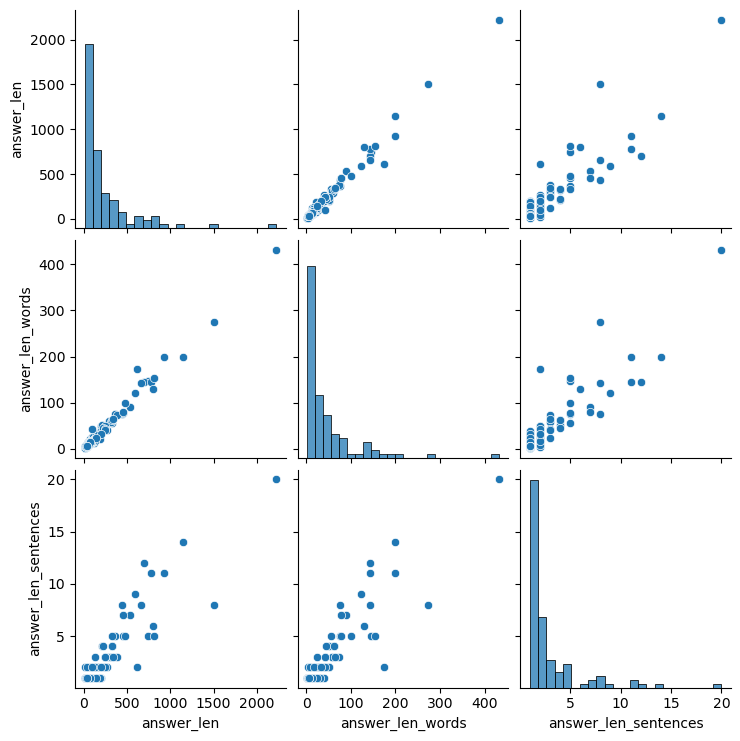

In [7]:
sns.pairplot(data = df, palette = 'Paired')
plt.show()

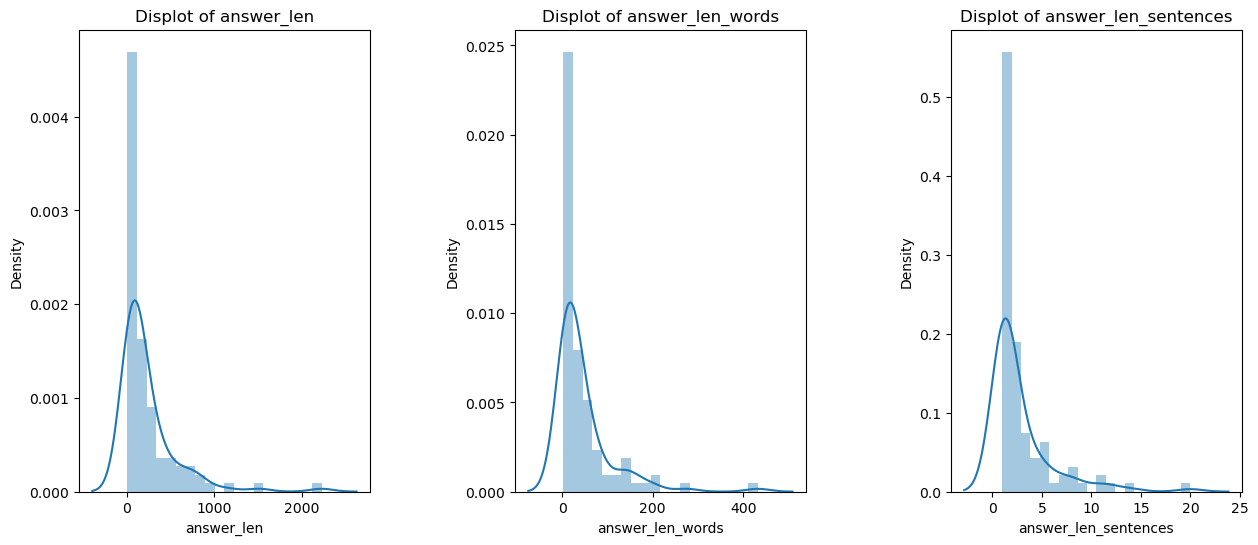

In [8]:
plt.figure(1, figsize = (15, 6))
n = 0
for x in ['answer_len', 'answer_len_words', 'answer_len_sentences']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace = .5, wspace = .5)
    sns.distplot(df[x], bins = 20)
    plt.title(f'Displot of {x}')
plt.show()

[UP](#toc)

<a id = 'annoy'></a>
<center>
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#212121;
           font-size:110%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#FFFFFF;">Annoy
</h2>
</div>    
</center>

- [Preprocess](#annoy_preprocess)
- [Word2Vec](#annoy_word2vec)
- [Result](#annoy_result)
- [Annoy](#annoy_annoy)

<a id = 'annoy_preprocess'></a>
<left>
<div style="color:white;
           display:fill;
           border: 0px;
           border-bottom: 2px solid #AAA;
           font-size:80%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#212121;">Preprocess
</h2>
</div>    
</left>

In [9]:
exclude = set(punctuation)
sw = set(get_stop_words('de'))
morpher = MorphAnalyzer()

def preprocess_text(line):
    spls = ''.join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != '']
    return spls

In [10]:
df['sentence'] = df['question'] + ' \t ' + df['answer']

sentences = []

for line in df['sentence']:
    sentences.append(preprocess_text(line))

<a id = 'annoy_word2vec'></a>
<left>
<div style="color:white;
           display:fill;
           border: 0px;
           border-bottom: 2px solid #AAA;
           font-size:80%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#212121;">Word2Vec
</h2>
</div>    
</left>

In [11]:
sentences = [i for i in sentences if len(i) > 2]
model = Word2Vec(sentences = sentences, vector_size = 100, min_count = 1, window = 5)
model.save('Assets/word2vec_model')

<a id = 'annoy_annoy'></a>
<left>
<div style="color:white;
           display:fill;
           border: 0px;
           border-bottom: 2px solid #AAA;
           font-size:80%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#212121;">Annoy
</h2>
</div>    
</left>

In [12]:
index = annoy.AnnoyIndex(100 ,'angular')

index_map = {}
counter = 0

for line in df['sentence']:
    n_w2v = 0
    spls = line.split('\t')
    index_map[counter] = spls[1]
    question = preprocess_text(spls[0])
    vector = np.zeros(100)
    for word in question:
        if word in model.wv:
            vector += model.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    index.add_item(counter, vector)

    counter += 1
    if counter > 100:
        break
        
index.build(10)
index.save('speaker.ann')

True

<a id = 'annoy_result'></a>
<left>
<div style="color:white;
           display:fill;
           border: 0px;
           border-bottom: 2px solid #AAA;
           font-size:80%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#212121;">Result
</h2>
</div>    
</left>

In [13]:
def answer_annoy(line):
    splt = preprocess_text(line)
    n_w2v = 0
    vector = np.zeros(100)
    for word in splt:
        if word in model.wv:
            vector += model.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    answer_index = index.get_nns_by_vector(vector, 1)
    return index_map[answer_index[0]]

In [14]:
answer_annoy('Wie viele Bucher gibt es Vampire Acadamy gibt es?')

' 4. Jäger und Gejagte, Eisbiss, Kuss der Dunkelheit, Blutschwur.'

In [15]:
answer_annoy('Flughafen Zürich benötige einen Lageplan des Flughafens Zürich')

' Sie brauchen keine Karte, dort ist alles klar und verständlich. Wenn Sie ein Transitpassagier sind, sollten Sie direkt zum Check-in-Schalter für Transitpassagiere gehen, Sie werden sich nicht verlaufen, dort sind viele Schilder angebracht!!!'

[UP](#toc)